## Space Weather Analysis and Geomagnetic Storm Prediction

## Getting Sunspot Data

In [137]:
import urllib.request
import pandas as pd
import numpy as np

In [138]:
obj = urllib.request.urlopen("http://www.sidc.be/silso/DATA/SN_d_tot_V2.0.txt")
obj

In [140]:
import sqlite3

In [236]:
df = pd.DataFrame(columns = ["Date", "Sunspot_count", "Sunspot_sd", "Observ_No"])

In [141]:
conn = sqlite3.connect("space.db", isolation_level=None)
cur = conn.cursor()
cur.execute('''
    CREATE TABLE sunspots (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    date DATE,
    sunspot_count INTEGER,
    sunspot_sd REAL,
    obs_id INTEGER
    );
    ''')

In [142]:
df.columns

Index(['date', 'sunspot_count', 'sunspot_sd', 'obs_id'], dtype='object')

In [143]:
for line in obj:
    row_bytes = line.split()

    date = row_bytes[0].decode("utf-8") + "-" + row_bytes[1].decode("utf-8") + "-" + row_bytes[2].decode("utf-8")    
    row_txt = [date, row_bytes[4].decode("utf-8"), row_bytes[5].decode("utf-8"), row_bytes[6].decode("utf-8")] 
    a_series = pd.Series(row_txt, index = df.columns)
    
    query = 'INSERT INTO sunspots (date, sunspot_count, sunspot_sd, obs_id) VALUES ("%s", "%s", "%s", "%s")' % (a_series["date"], a_series["sunspot_count"], a_series["sunspot_sd"], a_series["obs_id"])    
    cur.execute(query)

In [144]:
conn.commit()

In [252]:
cur.execute("SELECT * FROM sunspots WHERE CAST(strftime('%Y', date) AS INTEGER) > 1900")
sunspots = cur.fetchall()

## Formatting Data

In [246]:
df_ss = pd.DataFrame(columns = ["Date", "Sunspot_count", "Sunspot_sd", "Observ_No"])
df_ss = df_ss.append([pd.Series(row[1:], index = df_ss.columns) for row in sunspots])

/var/folders/0p/zxhq4z1j2wv76v8ysg1rhnc00000gn/T/ipykernel_16225/652635659.py:2: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [247]:
df_ss

,Date,Sunspot_count,Sunspot_sd,Observ_No
0,1901-10-01,0,2.0,1
1,1901-10-02,0,2.0,1
2,1901-10-03,0,2.0,1
3,1901-10-04,0,2.0,1
4,1901-10-05,0,2.0,1
...,...,...,...,...
13010,2022-11-26,74,11.4,28
13011,2022-11-27,69,6.0,28
13012,2022-11-28,52,10.4,27
13013,2022-11-29,29,5.8,15


## Sunspot Analysis & Visualization

In [37]:
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "svg"

In [248]:
sunspot_count_ordered = df_ss["Sunspot_count"].copy().sort_values(ascending=True)
sunspot_count_ordered.head()

0          0
11203      0
11202      0
11201      0
11197      0
        ... 
5180     473
5238     477
5235     486
5237     503
5236     503
Name: Sunspot_count, Length: 13015, dtype: object

In [249]:
sunspot_count_ordered = df_ss["Sunspot_count"].copy().sort_values(ascending=True)
q3_index = int(df_ss.shape[0] * 0.75)
q1_index = int(df_ss.shape[0] * 0.25)
iqr = sunspot_count_ordered.iloc[q3_index] - sunspot_count_ordered.iloc[q1_index]
threshold = sunspot_count_ordered.iloc[q3_index] + 2*iqr
print(df_ss["Sunspot_count"].min(), threshold, df_ss["Sunspot_count"].max())

0 327 503


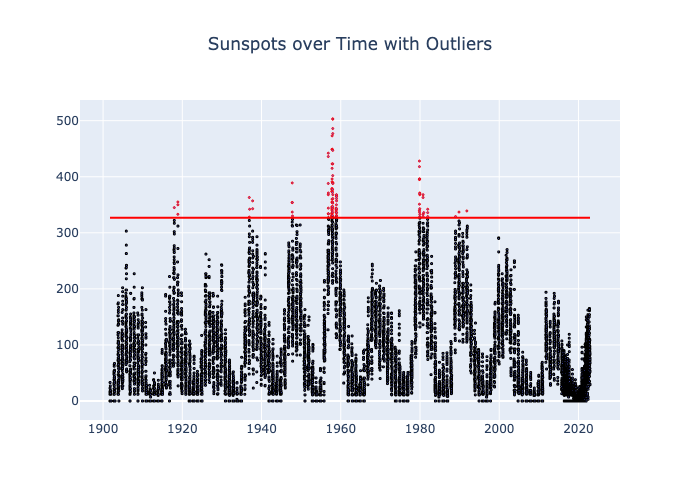

In [44]:
fig1 = px.scatter(df_ss[df_ss["Sunspot_count"] >= threshold], x="Date", y="Sunspot_count", title="Number of Sunspots over time")
fig2 = px.scatter(df_ss[df_ss["Sunspot_count"] < threshold], x="Date", y="Sunspot_count", title="Number of Sunspots over time")

fig1.update_traces(marker=dict(size=2,
                              line=dict(width=1,
                                        color='Red')),
                  selector=dict(mode='markers'))

fig2.update_traces(marker=dict(size=2,
                              line=dict(width=1,
                                        color='Red')),
                  selector=dict(mode='markers'))

layout = go.Layout(title='Sunspots over Time with Outliers', showlegend=True, title_x=0.5)
fig3 = go.Figure(data=fig1.data + fig2.data, layout=layout)


fig3.add_shape(
        type='line',
        x0=df_ss["Date"].min(),
        y0=threshold,
        x1=df_ss["Date"].max(),
        y1=threshold,
        line=dict(
            color="Red",
        )
)
fig3.show("png")

Outliers by the 2*iqr rule

## Plasma and Magnetic Field

In [ ]:
import json

In [112]:
mag=urllib.request.urlopen("https://services.swpc.noaa.gov/products/solar-wind/mag-7-day.json")
plasma= urllib.request.urlopen("https://services.swpc.noaa.gov/products/solar-wind/plasma-7-day.json")
mag_json=json.loads(mag.read())
plasma_json=json.loads(plasma.read())

In [155]:
cur.execute('''
    CREATE TABLE mag (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    date_time DATETIME,
    bx REAL,
    by REAL,
    bz REAL,
    bt REAL
    );
''')

cur.execute('''
    CREATE TABLE plasma (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    date_time DATETIME,
    density REAL,
    speed REAL,
    temp REAL
    );
    ''')

## Formatting Data

In [162]:
for line in mag_json[1:]:
    query = 'INSERT INTO mag (date_time, bx, by, bz, bt) VALUES ("%s", "%s", "%s", "%s", "%s")' % (line[0][:19], line[1], line[2], line[3], line[6])   
    cur.execute(query)
    
for line in plasma_json[1:]:
    query = 'INSERT INTO plasma (date_time, density, speed, temp) VALUES ("%s", "%s", "%s", "%s")' % (line[0][:19], line[1], line[2], line[3])   
    cur.execute(query)

conn.commit()

In [166]:
df_mag = pd.DataFrame(columns = ["Datetime", "Bx", "By", "Bz", "Bt"])
df_plasma = pd.DataFrame(columns = ["Datetime", "Density", "Speed", "Temperature"])

In [167]:
cur.execute("SELECT * FROM mag")
mag = cur.fetchall()
df_mag = df_mag.append([pd.Series(row[1:], index = df_mag.columns) for row in mag])

/var/folders/0p/zxhq4z1j2wv76v8ysg1rhnc00000gn/T/ipykernel_16225/272901314.py:3: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [168]:
cur.execute("SELECT * FROM plasma")
plasma = cur.fetchall()
df_plasma = df_plasma.append([pd.Series(row[1:], index = df_plasma.columns) for row in plasma])

/var/folders/0p/zxhq4z1j2wv76v8ysg1rhnc00000gn/T/ipykernel_16225/2672635088.py:3: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [169]:
print(df_mag.shape, df_plasma.shape)


(10025, 5) (9958, 4)


In [170]:
df_mag.head()

,Datetime,Bx,By,Bz,Bt
0,2022-12-07 22:44:00,-0.2,-5.0,1.4,5.28
1,2022-12-07 22:45:00,-1.68,-4.37,2.25,5.32
2,2022-12-07 22:46:00,-1.81,-1.53,2.14,4.35
3,2022-12-07 22:47:00,-3.32,-0.33,3.25,4.63
4,2022-12-07 22:48:00,-3.51,0.95,3.54,5.1


In [171]:
df_plasma.head()

,Datetime,Density,Speed,Temperature
0,2022-12-07 22:45:00,13.54,468.8,182798.0
1,2022-12-07 22:46:00,14.67,468.5,180535.0
2,2022-12-07 22:47:00,14.9,471.6,185962.0
3,2022-12-07 22:48:00,14.64,473.7,179293.0
4,2022-12-07 22:49:00,14.69,474.7,174562.0


## Visualization of Magnetic Field Values

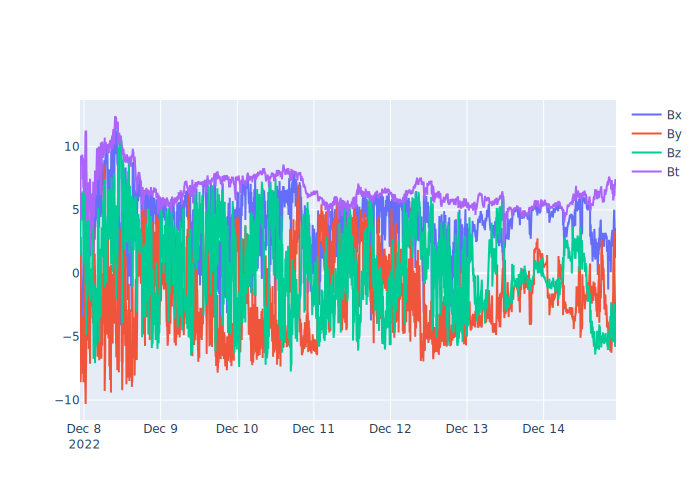

In [40]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=df_mag.Datetime,
        y=df_mag.Bx,
        name="Bx"
    ))
fig.add_trace(
    go.Scatter(
        x=df_mag.Datetime,
        y=df_mag.By,
        name="By"
    ))
fig.add_trace(
    go.Scatter(
        x=df_mag.Datetime,
        y=df_mag.Bz,
        name="Bz"
    ))
fig.add_trace(
    go.Scatter(
        x=df_mag.Datetime,
        y=df_mag.Bt,
        name="Bt"
    ))
fig.show()


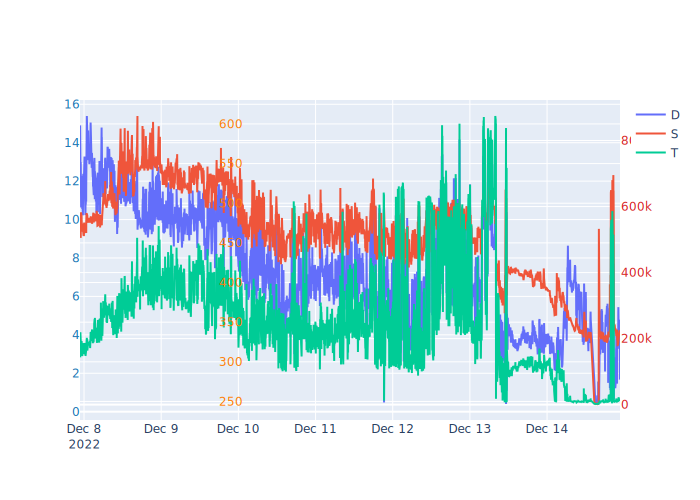

In [41]:
fig1 = go.Figure()

fig1.add_trace(go.Scatter(
    x=df_plasma.Datetime,
    y=df_plasma.Density,
    name="D"
))

fig1.add_trace(go.Scatter(
    x=df_plasma.Datetime,
    y=df_plasma.Speed,
    name="S",
    yaxis="y2"
))

fig1.add_trace(go.Scatter(
    x=df_plasma.Datetime,
    y=df_plasma.Temperature,
    name="T",
    yaxis="y3"
))

fig1.update_layout(
    yaxis=dict(
        tickfont=dict(
            color="#1f77b4"
        ),
        side="left"
    ),
    yaxis2=dict(
        tickfont=dict(
            color="#ff7f0e"
        ),
        anchor="free",
        overlaying="y",
        side="left",
        position=0.3
    ),
    yaxis3=dict(
        tickfont=dict(
            color="#d62728"
        ),
        anchor="x",
        overlaying="y",
        side="right"
    )
)
fig1.show()

## Analysis and Curve Fitting

In [174]:
df_plasma["timestep"] = np.arange(len(df_plasma.Datetime))

In [175]:
df_plasma.head()

,Datetime,Density,Speed,Temperature,timestep
0,2022-12-07 22:45:00,13.54,468.8,182798.0,0
1,2022-12-07 22:46:00,14.67,468.5,180535.0,1
2,2022-12-07 22:47:00,14.9,471.6,185962.0,2
3,2022-12-07 22:48:00,14.64,473.7,179293.0,3
4,2022-12-07 22:49:00,14.69,474.7,174562.0,4


In [176]:
df_plasma.replace(to_replace="None",
           value=0, inplace=True)

In [177]:
from sklearn.linear_model import LinearRegression

X = df_plasma.loc[:, ["timestep"]]

train_y_temp = df_plasma.loc[:, "Temperature"]
train_y_speed = df_plasma.loc[:, "Speed"]

temp_model = LinearRegression()
speed_model = LinearRegression()

temp_model.fit(X, train_y_temp)
speed_model.fit(X, train_y_speed)

temp_pred = pd.Series(temp_model.predict(X))
speed_pred = pd.Series(speed_model.predict(X))

print(temp_pred.head(3), speed_pred.head(3))

0    345836.800138
1    345817.742361
2    345798.684584
dtype: float64 0    547.179602
1    547.162891
2    547.146180
dtype: float64


In [178]:
temp_pred

0       345836.800138
1       345817.742361
2       345798.684584
3       345779.626807
4       345760.569030
            ...      
9953    156154.746094
9954    156135.688317
9955    156116.630540
9956    156097.572763
9957    156078.514986
Length: 9958, dtype: float64

In [179]:
df_plasma["temp_pred"] = temp_pred
df_plasma["speed_pred"] = speed_pred

In [180]:
df_plasma

,Datetime,Density,Speed,Temperature,timestep,temp_pred,speed_pred
0,2022-12-07 22:45:00,13.54,468.8,182798.0,0,345836.800138,547.179602
1,2022-12-07 22:46:00,14.67,468.5,180535.0,1,345817.742361,547.162891
2,2022-12-07 22:47:00,14.9,471.6,185962.0,2,345798.684584,547.146180
3,2022-12-07 22:48:00,14.64,473.7,179293.0,3,345779.626807,547.129470
4,2022-12-07 22:49:00,14.69,474.7,174562.0,4,345760.569030,547.112759
...,...,...,...,...,...,...,...
9953,2022-12-14 22:37:00,3.86,336.0,17606.0,9953,156154.746094,380.858982
9954,2022-12-14 22:38:00,3.81,334.6,17829.0,9954,156135.688317,380.842272
9955,2022-12-14 22:39:00,3.35,334.0,18156.0,9955,156116.630540,380.825561
9956,2022-12-14 22:40:00,1.67,337.9,11091.0,9956,156097.572763,380.808850


## Visualizing Speed and Temperature Trends

In [181]:
import seaborn as sns

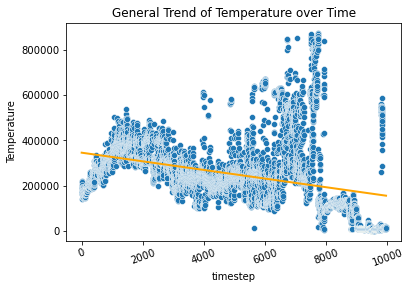

In [234]:
sns.scatterplot(x="timestep", y="Temperature", data=df_plasma)
sns.lineplot(x="timestep", y="temp_pred", data=df_plasma, color="orange", linewidth=2)
plt.xticks(rotation=20)
plt.title("General Trend of Temperature over Time")
plt.show()

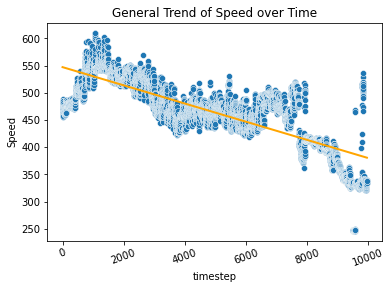

In [235]:
sns.scatterplot(x="timestep", y="Speed", data=df_plasma)
sns.lineplot(x="timestep", y="speed_pred", data=df_plasma, color="orange", linewidth=2)
plt.xticks(rotation=20)
plt.title("General Trend of Speed over Time")
plt.show()

In [183]:
df_plasma["Datetime"].describe()

count                    9958
unique                   9958
top       2022-12-07 22:45:00
freq                        1
Name: Datetime, dtype: object

In [209]:
daily_data = df_plasma[df_plasma["Datetime"] > "2022-12-12"]
daily_data

,Datetime,Density,Speed,Temperature,timestep,temp_pred,speed_pred
5809,2022-12-12 00:00:00,4.32,437.5,159136.0,5809,235130.173800,450.107716
5810,2022-12-12 00:01:00,4.21,438.4,148640.0,5810,235111.116023,450.091005
5811,2022-12-12 00:02:00,6.27,458.8,264525.0,5811,235092.058246,450.074295
5812,2022-12-12 00:03:00,6.66,462.9,232220.0,5812,235073.000469,450.057584
5813,2022-12-12 00:04:00,7.88,473.3,311835.0,5813,235053.942692,450.040873
...,...,...,...,...,...,...,...
9953,2022-12-14 22:37:00,3.86,336.0,17606.0,9953,156154.746094,380.858982
9954,2022-12-14 22:38:00,3.81,334.6,17829.0,9954,156135.688317,380.842272
9955,2022-12-14 22:39:00,3.35,334.0,18156.0,9955,156116.630540,380.825561
9956,2022-12-14 22:40:00,1.67,337.9,11091.0,9956,156097.572763,380.808850


## Polynomial Regression and Model Tuning

In [210]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

degrees = [1, 2, 3, 4, 5, 6]
errors = []
for d in degrees:
    poly = PolynomialFeatures(degree=d, include_bias=False)
    X = daily_data["timestep"].to_numpy()
    features = poly.fit_transform(X.reshape(-1, 1))
    globals()["ModelDeg" + str(d)] = LinearRegression()
    globals()["ModelDeg" + str(d)].fit(features , daily_data["Temperature"])
    globals()["y_pred" + str(d)] = pd.Series(globals()["ModelDeg" + str(d)].predict(features))
    rmse = mean_squared_error(daily_data["Temperature"], globals()["y_pred" + str(d)]) ** .5
    errors.append(rmse)
errors

[173671.1958668716,
 168921.71317792402,
 153203.73930544802,
 152883.8582066123,
 153131.2571684798,
 152766.4637710652]

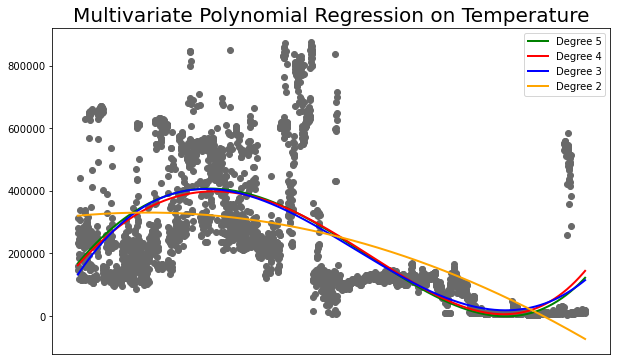

In [224]:
plt.figure(figsize=(10, 6))
plt.title("Multivariate Polynomial Regression on Temperature", size=20)
plt.scatter(daily_data["timestep"], daily_data["Temperature"], c="dimgrey")
plt.plot(daily_data["timestep"], y_pred5, c="Green", linewidth=2, label="Degree 5")
plt.plot(daily_data["timestep"], y_pred4, c="red", linewidth=2, label="Degree 4")
plt.plot(daily_data["timestep"], y_pred3, c="Blue", linewidth=2, label="Degree 3")
plt.plot(daily_data["timestep"], y_pred2, c="Orange", linewidth=2, label="Degree 2")
plt.tick_params(
    axis="x",
    which="both",
    bottom=False,
    labelbottom=False
)
plt.legend()
plt.show()

In [229]:
degrees = [1, 2, 3, 4, 5, 6]
errors = []
for d in degrees:
    poly = PolynomialFeatures(degree=d, include_bias=False)
    X = daily_data["timestep"].to_numpy()
    features = poly.fit_transform(X.reshape(-1, 1))
    globals()["ModelDeg" + str(d)] = LinearRegression()
    globals()["ModelDeg" + str(d)].fit(features , daily_data["Speed"])
    globals()["y_pred" + str(d)] = pd.Series(globals()["ModelDeg" + str(d)].predict(features))
    rmse = mean_squared_error(daily_data["Speed"], globals()["y_pred" + str(d)]) ** .5
    errors.append(rmse)
errors

[38.196679042157484,
 34.79894759346094,
 31.068392476613838,
 30.591247166363914,
 30.590221963051302,
 30.578303981094507]

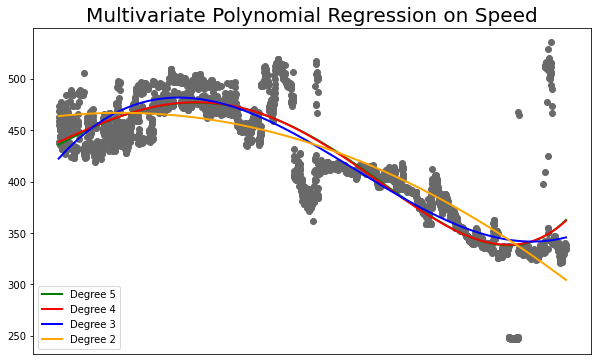

In [250]:
plt.figure(figsize=(10, 6))
plt.title("Multivariate Polynomial Regression on Speed", size=20)
plt.scatter(daily_data["timestep"], daily_data["Speed"], c="dimgrey")
plt.plot(daily_data["timestep"], y_pred5, c="Green", linewidth=2, label="Degree 5")
plt.plot(daily_data["timestep"], y_pred4, c="red", linewidth=2, label="Degree 4")
plt.plot(daily_data["timestep"], y_pred3, c="Blue", linewidth=2, label="Degree 3")
plt.plot(daily_data["timestep"], y_pred2, c="Orange", linewidth=2, label="Degree 2")
plt.tick_params(
    axis="x",
    which="both",
    bottom=False,
    labelbottom=False
)
plt.legend()
plt.show()

By the seasonal trend of speed and temperature, it shows that both may be at their local minimum.